In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score, silhouette_score
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))

In [2]:
kleister = pd.read_csv('/home/becode/AI/Data/Faktion/kleister-charity/test-A/in.tsv', sep='\t', names=['filename', 'keys', 'text_djvu', 'text_tesseract', 'text_textract', 'text_best'])
#print(kleister.head())
print(kleister.shape)
kleister = kleister.dropna()
print(kleister.shape)
kleister =kleister.drop(columns=['keys', 'text_djvu','text_textract','text_best'])
kleister['text_tesseract'] = kleister['text_tesseract'].astype(str)
kleister['text_tesseract'] = kleister['text_tesseract'].apply(lambda x: x.replace("\n",""))
kleister['text_tesseract'] = kleister['text_tesseract'].apply(lambda x: x.replace("\\n",""))

(609, 6)
(592, 6)


In [3]:
# Tokenize+Lemmatize sentence and word
def tokenize_lem(text):
    lem = WordNetLemmatizer()
    # stem = PorterStemmer() Lem is better
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.match('[a-zA-Z]', token) and not token in stop_words and len(token)>3: # changed from if re.search('[a-zA-Z]', token)
            lemmatized_word = lem.lemmatize(token)#, 'v')
            filtered_tokens.append(lemmatized_word)
            #stemmed = stem.stem(token)
            #filtered_tokens.append(stemmed)
    
    return filtered_tokens

In [18]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df= 0.8, min_df= 0,max_features=10000, stop_words=None,use_idf=True, tokenizer=tokenize_lem)#, ngram_range=(1,3))
X = kleister['text_tesseract'] #max_df= 0.8, min_df= 0.2, max_df= 0.95, min_df= 0.05,
tfidf_matrix = tfidf_vectorizer.fit_transform(X) #fit the vectorizer

print(tfidf_matrix.toarray())
df1 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
print(df1)

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
#print(terms)
print(tfidf_vectorizer.vocabulary_)
print(len(tfidf_vectorizer.vocabulary_))
X_reduced = tfidf_matrix
#print(kleister.head())

[[0.         0.         0.         ... 0.         0.00425263 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00668788]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
     a'true  a-level  a-levels  a3an3    abasis  abbey  abdelmoneim  abdul  \
0       0.0      0.0       0.0    0.0  0.000000    0.0          0.0    0.0   
1       0.0      0.0       0.0    0.0  0.000000    0.0          0.0    0.0   
2       0.0      0.0       0.0    0.0  0.000000    0.0          0.0    0.0   
3       0.0      0.0       0.0    0.0  0.000000    0.0          0.0    0.0   
4       0.0      0.0       0.0    0.0  0.000000    0.0          0.0    0.0   
..      ...      ...       ...    ...       ...    ...          ...    ...   
587     0.

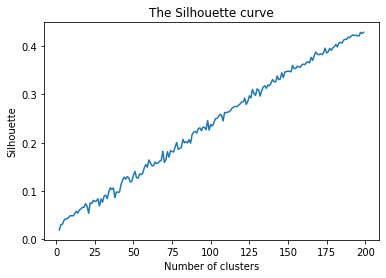

In [20]:
n_clusters=200
sil_scores=[]
for i in range(2,n_clusters):  # n_clusters can not be 1, took me a really long time to change the range from range(1, n) to (2,n)
    kmeans = KMeans(i)
    labels = kmeans.fit_predict(X_reduced) # or kmeans.labels_ is the same
    sil_scores.append(silhouette_score(X_reduced,labels))
plt.plot(range(2,200),sil_scores)
plt.title('The Silhouette curve')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

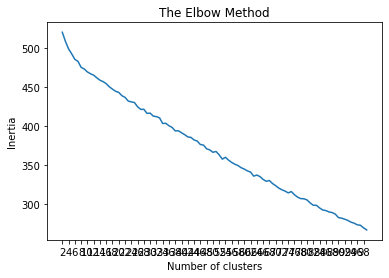

In [22]:
# Elbow curve : inertia vs k
n_clusters=100
cost=[]
for i in range(2,n_clusters):
    kmeans= KMeans(i)
    kmeans.fit(tfidf_matrix)
    cost.append(kmeans.inertia_)
plt.plot(range(2,100),cost)
plt.xticks(range(2,100,2))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



# Try vectorizing with more restricted params as to get smaller vector space

In [4]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df= 0.8, min_df= 0.2,max_features=1000, stop_words=None,use_idf=True, tokenizer=tokenize_lem)#, ngram_range=(1,3))
X = kleister['text_tesseract'] #max_df= 0.8, min_df= 0.2, max_df= 0.95, min_df= 0.05,
tfidf_matrix = tfidf_vectorizer.fit_transform(X) #fit the vectorizer

print(tfidf_matrix.toarray())
df1 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
print(df1)

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
#print(terms)
print(tfidf_vectorizer.vocabulary_)
print(len(tfidf_vectorizer.vocabulary_))
X_reduced = tfidf_matrix
#print(kleister.head())

[[0.00634135 0.00568079 0.05769893 ... 0.         0.00638205 0.01139549]
 [0.00929404 0.02775302 0.08673333 ... 0.         0.         0.01484579]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.0170008  0.01522987 0.         ... 0.         0.17109909 0.00678903]
 [0.03419139 0.         0.         ... 0.         0.         0.1638463 ]
 [0.02394262 0.037535   0.         ... 0.00770815 0.01204814 0.        ]]
      ability      able  academic    accept  accepted    access  \
0    0.006341  0.005681  0.057699  0.003356  0.008074  0.013215   
1    0.009294  0.027753  0.086733  0.006557  0.007889  0.032281   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.038997  0.000000  0.054588  0.000000  0.000000  0.000000   
4    0.000000  0.021195  0.000000  0.000000  0.000000  0.016435   
..        ...       ...       ...       ...       ...       ...   
587  0.000000  0.081755  0.000000  0.000000  0.000000  0.000000   
588  0.006256  0.061

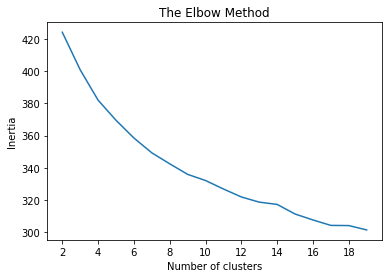

In [90]:
# Elbow curve : inertia vs k
n_clusters=20
cost=[]
for i in range(2,n_clusters):
    kmeans= KMeans(i)
    kmeans.fit(tfidf_matrix)
    cost.append(kmeans.inertia_)
plt.plot(range(2,20),cost)
plt.xticks(range(2,20,2))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=100, init='k-means++',n_init=10, max_iter=300, random_state=123 ) #287
kmeans.fit(X_reduced)
y=kmeans.predict(X_reduced)
print(y)
print(f"labels: {kmeans.labels_}") # y and kmeans.labels_ is same
clusters = kmeans.labels_.tolist()
print(clusters)
print(f"silhouette score = {silhouette_score(tfidf_matrix ,kmeans.labels_)}")
kleister['cluster'] = clusters
print(kleister['cluster'].value_counts())
kl = kleister.groupby('cluster')
print(kl)

In [56]:
dbscan = DBSCAN(eps=0.75, min_samples=2)
dbscan.fit_predict(tfidf_matrix)
print(dbscan.labels_)
print(f"silhouette score = {silhouette_score(tfidf_matrix ,dbscan.labels_)}")

[  0   1   2   3   4   5  -1   4   0   6   7  -1   8   4   9  10   0  11
  12  -1  13  14  15  16  17  18  19  20   0  21  22  23  24  25  26   4
  27  28  29  -1  30  -1  -1  31  32  -1  33   0  34  35   1  -1  36  37
  20  38   9   0  39   8  19  40   0  17  41  42   2  43   4  44   0   4
  45  46  47  48  49  47  -1  -1  50  47  51  46  52  53  54  55  56  57
  58  -1   0  59  60  61  42  -1  62  12  63   0   0  47   0  64   4  65
  66   1  67  68  -1  -1  69  70   0  -1  71   0  72  73   1  57  74  75
  11   4  76  -1  77  78  50   9  79  -1  80  11   0   1  18  81  82  83
  84   1  85  76  86  87  -1  -1  -1  88  89  90  91  92  93   4  94  95
  59  96   4  97  98   4  99   4 100  -1 101 102  -1 103  -1 104   0  -1
  98 105 106  76   0 107  -1   4 104 108 109 110 111  -1 112 113   9   8
 114 115 116   4 117 118  -1 109   4  44 119  28   0  13 120 121 122 123
  44 124   4   0   1  -1  66 125 126 127  33  37 128   4 129  -1  -1 130
  11  40 131  12 132 133 134  -1  86   1   8 135  8

In [72]:
#dblab = pd.DataFrame(dbscan.labels_, columns='cluster')
dblab = pd.DataFrame({'cluster' : dbscan.labels_})#, columns='cluster')
print(dblab)

     cluster
0          0
1          1
2          2
3          3
4          4
..       ...
587       -1
588       91
589      142
590       -1
591       82

[592 rows x 1 columns]


In [73]:
print(dblab[dblab.cluster == -1])

     cluster
6         -1
11        -1
19        -1
39        -1
41        -1
..       ...
581       -1
582       -1
584       -1
587       -1
590       -1

[112 rows x 1 columns]


In [74]:
print(dblab[dblab.cluster == -1].count())

cluster    112
dtype: int64


In [91]:
print(dblab.cluster.value_counts())

-1     112
 0      45
 4      35
 1      17
 8      11
      ... 
 95      2
 96      2
 97      2
 99      2
 73      2
Name: cluster, Length: 149, dtype: int64


In [95]:
percentages = dblab[dblab.cluster.value_counts() / dblab.cluster.value_counts().sum *100]

TypeError: Cannot broadcast np.ndarray with operand of type <class 'method'>

In [81]:
kleister['cluster'] = dblab['cluster'].astype(str)
print(kleister.head(25))

                                filename  \
0   abbf98ed31e28068150dce58296302ee.pdf   
1   f3e363848aea2fa645814f2de0221a5a.pdf   
2   62acdd1bbd0dfeea27da2720eb795449.pdf   
3   e734bc7dfc9b37c5dd2c3a37693062e8.pdf   
4   cb6b0949a2f9294750e436f7ea2f10ce.pdf   
5   87c977ccb9bdf111b1397e9c4ada2470.pdf   
6   39df988309a04c631445b04ebd6a4a53.pdf   
7   e38bd1524e145b49edf991ab8f3e153d.pdf   
8   bb80583ada5875ccb4690ffa22f97bab.pdf   
9   7ae3665305caf119acabb0863ea1e46d.pdf   
10  dfe49a61d083ec665db91184150d1f51.pdf   
11  d407188b117523da08f8410e392fb2a5.pdf   
12  1fb9abd2c01f71c34d1de0106858ae57.pdf   
13  2a1e0d3371835da70449eca9a93df0cf.pdf   
14  e0034978b59a53c6f607c8ac9d04fe9e.pdf   
15  5ca7d4dbb023922f49e741d81821b689.pdf   
16  6332f7cf09190bf30752c947a0a686fd.pdf   
17  6c6254ab7171b47e41cce228253b9063.pdf   
19  a5c40991580e19fa0effc99c3bb70eed.pdf   
20  e0a0aba889bb94a69d90e74127d9c2d9.pdf   
21  2c15c83ae6bafc13ed2b5e434e603a37.pdf   
22  e2cabb3dfb4192d0d913611b6828

In [87]:
#kleister['filename']= kleister['filename'].apply(lambda x :)
check = kleister.drop(['text_tesseract'], axis=1)
print(check.head())

                               filename cluster
0  abbf98ed31e28068150dce58296302ee.pdf       0
1  f3e363848aea2fa645814f2de0221a5a.pdf       1
2  62acdd1bbd0dfeea27da2720eb795449.pdf       2
3  e734bc7dfc9b37c5dd2c3a37693062e8.pdf       3
4  cb6b0949a2f9294750e436f7ea2f10ce.pdf       4


In [89]:
check.to_csv('/home/becode/AI/Data/Faktion/check.csv')